# 13 - Difference-in-Differences

## Three Billboards in the South of Brazil

제가 마케팅 분야에서 일할 때 가장 효과를 본 방법은 인터넷 광고였습니다. 경제적인 방법일 뿐만 아니라 얼마나 효과적인지 쉽게 확인할 수 있기 때문입니다. 광고를 본 사용자의 쿠키를 추적하면 랜딩 페이지에서 이탈했는지, 다운로드 버튼을 클릭했는지 확인할 수 있습니다. 기계학습으로 광고에 민감한 사용자를 찾아 효과적인 마케팅을 할 수도 있습니다. 고객의 응답을 확인할 수 있다는 점에서 온라인 광고는 매우 정확합니다.

하지만 온라인 광고에 둔감한 사람도 있습니다. 때로는 TV 광고나 거리의 광고판과 같이 덜 정확한 방법에 의존해야 합니다. 보통 마케팅 담당 부서에서 다양한 광고 채널을 고민합니다. 온라인 광고가 원하는 참치를 잡기 위한 전문적인 낚싯대라면, TV 광고와 길거리 광고판은 물고기 떼에 던지는 거대한 그물입니다. 적어도 몇 마리의 큰 참치가 걸려들기를 기대합니다. 다만 오프라인 광고는 효과를 파악하기 어렵습니다. 물론 길거리 광고판 설치 전후의 매출을 비교할 수는 있습니다. 만약 매출이 증가했다면 광고판이 효과적이라는 증거가 됩니다. 하지만 매출의 증가는 자연스러운 제품의 인지도 상승에 의한 것일 수도 있습니다. 광고판을 설치하지 않았을 때 매출인 `counterfactual` $Y_0$를 알 수 있을까요?

![img](./data/img/diff-in-diff/secrets.png)

문제를 다루는 한 가지 기술은 `Difference-in-Difference`(혹은 `Diff-in-Diff`)입니다. `Diff-in-Diff`는 일반적으로 이민에 대한 실업의 영향, 총기법에 따른 범죄율 변화, 마케팅에 의한 사용자 참여율 변화와 같은 큰 개입의 영향을 평가할 때 사용합니다. 개입 전후에 긴 기간을 두고 개입의 영향을 일반적인 추세로부터 분리하려 합니다. 제가 예전에 다루었던 문제를 소개하겠습니다.

광고의 효과를 알아보기 위해 히우그란지두술주의 주도인 포르투알레그리에 광고판 3개를 배치했습니다. (히우그란지두술은 브라질 남부에 있는 가장 발달한 지역 중 하나입니다.) 목적은 광고가 저축을 촉진하는지 조사하는 것입니다.

추가로 브라질 남부 산타카타리나주의 주도, 플로리아노폴리스의 데이터도 살펴봤습니다. 플로리아노폴리스를 대조군으로 사용해 포르투알레그리의 `counterfactual` $Y_0$를 추정하고자 합니다. (진짜로 이렇게 하지는 않았지만 비슷합니다. 비밀이지만요.) 포르투알레그리의 광고판은 6월 한 달 동안 배치했습니다. 

데이터는 다음과 같습니다.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
%matplotlib inline

style.use("fivethirtyeight")

In [2]:
data = pd.read_csv("data/billboard_impact.csv")
data.head()

,deposits,poa,jul
0,42,1,0
1,0,1,0
2,52,1,0
3,119,1,0
4,21,1,0


`deposits`(예금)은 `outcome`으로 광고에 따라 커지길 기대하는 변수입니다. `POA`는 포르투알레그리를 나타내는 더미변수입니다. 0은 플로리아노폴리스를 의미합니다. `Jul`은 7월을 나타내는 더미변수입니다. `Jul이 0이면 개입 전인 5월, 1이면 개입 후인 7월을 뜻합니다.

## DID Estimator

기간과 개입을 구분하기 위해 기간은 `T`로 개입은 `D`로 표기하겠습니다. $Y_D(T)$는 개입 `D`에 대한 기간 `T`의 `potential outcome`입니다. `counterfactual`을 알 수 있는 이상적인 세계에서는 아래와 같이 개입의 효과를 추정할 수 있습니다.

$
\hat{ATET} = E[Y_1(1) - Y_0(1)|D=1]
$

즉, 인과효과는 개입 후 기간의 개입 전후 `outcome`의 차이입니다. 물론 $Y_0(1)$는 `counterfactual`이므로 측정할 수 없습니다.

문제를 해결하는 한 가지 방법은 개입 전후를 비교하는 것입니다.

$
\hat{ATET} = E[Y(1)|D=1] - E[Y(0)|D=1]
$

예시에서는 광고판이 설치되기 전후 `POA`의 평균 예금을 비교합니다.

In [3]:
poa_before = data.query("poa==1 & jul==0")["deposits"].mean()

poa_after = data.query("poa==1 & jul==1")["deposits"].mean()

poa_after - poa_before

41.04775

결과는 개입 후 예금이 41.04 헤알 늘어날 것으로 기대합니다. 하지만 결과를 믿을 수 있을까요?

$E[Y(0)|D=1]$는 $E[Y_0(0)|D=1]$와 같습니다. 즉, **개입 전** 실험군의 `outcome`은 개입 전 실험군의 `counterfactual outcome`과 같습니다. 여기서는 **개입 후**의 `counterfactual` $E[Y_0(1)|D=1]$를 추정하는 데 사용하므로 $E[Y_0(1)|D=1] = E[Y_0(0)|D=1]$를 가정합니다.

개입이 없었다면 5월과 7월의 `outcome`이 같다는 의미입니다. 만약 `outcome`이 어떤 추세를 가지면 추정치는 틀리게 됩니다. 만약 `POA`에서 예금이 늘어나고 있으면 $E[Y_0(1)|D=1] > E[Y_0(0)|D=1]$입니다. 개입이 없더라도 7월의 예금이 더 많을 것입니다. 비슷하게 예금의 추세가 감소하고 있다면 $E[Y_0(1)|D=1] < E[Y_0(0)|D=1]$입니다. 따라서 단순히 개입 전후를 비교하면 좋은 추정치를 얻을 수 없습니다.

다른 아이디어는 같은 기간 내 실험군과 대조군을 비교하는 것입니다.

$
\hat{ATET} = E[Y(1)|D=1] - E[Y(1)|D=0]
$

예시에서는 개입 후 포르투알레그리의 예금과 플로리아노폴리스의 예금을 비교합니다.

In [4]:
fl_after = data.query("poa==0 & jul==1")["deposits"].mean()
poa_after - fl_after

-119.10175000000001

결과는 광고판이 악영향을 주어 119.10 헤알만큼 예금을 줄일 것을 기대합니다.

$E[Y(1)|D=0]=E[Y_0(1)|D=0]$임에 유의하세요. $E[Y(1)|D=0]$를 개입 후 실험군의 `counterfactual`을 구할 때 사용하므로 $E[Y_0(1)|D=0] = E[Y_0(1)|D=1]$임을 가정합니다. 이 가정은 두 그룹의 `outcome` 수준이 매우 유사할 때 만족합니다. 플로리아노폴리스의 예금 수준이 포르투알레그리의 예금 수준보다 훨찐 높다면 $E[Y_0(1)|D=0] > E[Y_0(1)|D=1]$이므로 가정이 틀립니다. 반대라면 $E[Y_0(1)|D=0] < E[Y_0(1)|D=1]$입니다.

이 방법도 좋지 않네요. 해결 방법은 지역과 기간을 모두 비교하는 것입니다. `Diff-in-Diff`의 기본 아이디어는 누락된 `counterfactual`를 아래와 같이 대체하는 것입니다.

$
E[Y_0(1)|D=1] = E[Y_1(0)|D=1] + (E[Y_0(1)|D=0] - E[Y_0(0)|D=0])
$

**개입 전** 실험군을 선택하고 추세를 더합니다. 추세선은 $E[Y_0(1)|D=0] - E[Y_0(0)|D=0]$으로 얻습니다. 즉, **개입 후** 실험군이 개입을 받지 않았다면 **개입 전 실험군**에 추세를 더한 것과 같습니다.

실험군과 대조군의 추세가 같다고 가정함에 유의해야 합니다.

$
E[Y_0(1) − Y_0(0)|D=1] = E[Y_0(1) − Y_0(0)|D=0]
$

왼쪽은 `counterfactual` 추세입니다. 이제 개입 효과의 정의 $E[Y_1(1)|D=1] - E[Y_0(1)|D=1]$ 내 `counterfactual`을 대체할 수 있습니다.

$
\hat{ATET} = E[Y(1)|D=1] - (E[Y(0)|D=1] + (E[Y(1)|D=0] - E[Y(0)|D=0])
$

항을 정렬하면 고전적인 `Diff-in-Diff` 추정기를 얻습니다.

$
\hat{ATET} = (E[Y(1)|D=1] - E[Y(1)|D=0]) - (E[Y(0)|D=1] - E[Y(0)|D=0])
$

`Difference-in-Difference`의 이름은 개입 전후로 실험군과 대조군을 비교하는 특징에서 유래합니다.

코드는 아래와 같습니다.

In [5]:
fl_before = data.query("poa==0 & jul==0")["deposits"].mean()

diff_in_diff = (poa_after-poa_before)-(fl_after-fl_before)
diff_in_diff

6.524557692307688

`Diff-in-Diff`의 결과는 고객당 6.52 헤알 예금이 증가할 것으로 기대합니다. `Diff-in-Diff`의 그럴듯한 가정(두 도시 사이의 추세가 같음)에 따라 6.52는 다른 추정치보다 더 신뢰할 수 있습니다. 예금 수준이 같거나 추세가 0일 필요가 없습니다.

`Diff-in-Diff`가 무엇을 하고 있는지 시각화해보겠습니다. 대조군의 추세를 실험군에 반영해 `counterfactual`, 즉 개입이 없었을 때 기대하는 예금을 표현할 수 있습니다.

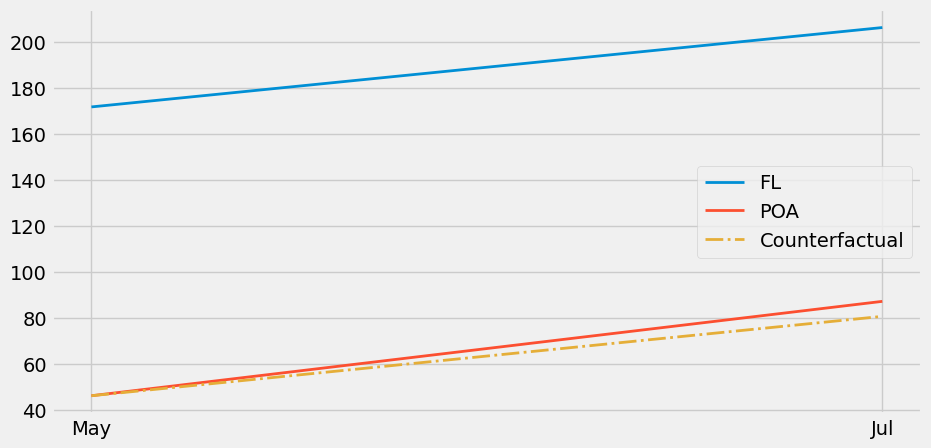

In [6]:
plt.figure(figsize=(10,5))
plt.plot(["May", "Jul"], [fl_before, fl_after], label="FL", lw=2)
plt.plot(["May", "Jul"], [poa_before, poa_after], label="POA", lw=2)

plt.plot(["May", "Jul"], [poa_before, poa_before+(fl_after-fl_before)],
         label="Counterfactual", lw=2, color="C2", ls="-.")

plt.legend();

빨간색 실선과 노란색 점선 사이의 작은 차이가 보이시죠? 정말 집중하면 포르투알레그리에 대한 작은 개입 효과를 볼 수 있습니다.

![img](./data/img/diff-in-diff/cant-read.png)

이제 "추정치를 얼마나 신뢰할 수 있습니까?"라는 질문에 답해봅시다. 표준 오차를 계산하는 것은 우리의 의무입니다! 표준 오차가 없는 추정치는 멍청해 보이기 때문입니다. 선형회귀를 사용하는 깔끔한 트릭을 소개해 드리겠습니다. 아래와 같은 선형 모델을 추정합니다.

$
Y_i = \beta_0 + \beta_1 POA_i + \beta_2 Jul_i + \beta_3 POA_i*Jul_i + e_i
$

$\beta_0$는 대조군의 베이스라인입니다. 예시에서는 5월의 플로리아노폴리스의 예금 수준입니다. `POA`가 1이면 $\beta_1$을 얻습니다. $\beta_0 + \beta_1$은 개입 전인 5월의 포르투알레그리의 베이스라인으로 $\beta_1$은 플로리아노폴리스 대비 포르투알레그리의 증가량입니다. `POA`를 0으로 하고 `Jul`을 1로 바꾸면 개입 후 7월 플로리아노폴리스 예금 수준인 $\beta_0 + \beta_2$가 나옵니다. $\beta_2$는 대조군의 추세입니다. 베이스라인에 더하면 개입 후 대조군의 수준을 구할 수 있습니다. 요약하자면 $\beta_1$은 대조군에서 실험군으로 바뀌면서 얻는 증가량, $\beta_2$는 개입 전에서 개입 후로 바뀌면서 얻는 증가량입니다. `POA`, `Jul`이 모두 1이면 $\beta_3$와 같습니다. $\beta_0 + \beta_1 + \beta_2 + \beta_3$는 개입 후 포르투알레그리의 수준입니다. 즉, $\beta_3$는 5월에서 7월, 플로리아노폴리스에서 포르투알레그리로 이동할 때 얻는 영향입니다. 위 수식은 `Diff-in-Diff`를 표현한 것입니다.

코드를 확인해 봅시다. 앞의 결과인 6.52와 같은 숫자를 얻어야 합니다. 표준 오차가 어떻게 나오는지도 확인해 봅시다.

In [7]:
smf.ols('deposits ~ poa*jul', data=data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,171.6423,2.363,72.625,0.000,167.009,176.276
poa,-125.6263,4.484,-28.015,0.000,-134.418,-116.835
jul,34.5232,3.036,11.372,0.000,28.571,40.475
poa:jul,6.5246,5.729,1.139,0.255,-4.706,17.755


## Non Parallel Trends

`Diff-in-Diff`의 한 가지 문제는 `parallel trend assumption`(평행 추세 가정)이 깨질 때 발생합니다. 실험군과 대조군의 추세가 다르면 `Diff-in-Diff`의 결과는 편향됩니다. 일반적으로 무작위 실험이 아닌 데이터에서 많이 보이는 문제입니다. 앞의 광고판 사례로 설명해보겠습니다. 우리는 포르투알레그리에서 광고판의 효과를 테스트했습니다. 포르투알레그리를 선택한 이유는 단순히 이 지역의 실적이 좋지 않기 때문입니다. 아마도 온라인 마케팅의 효과가 작기 때문일 것입니다. 따라서 포르투알레그리의 추세는 다른 도시의 추세보다 낮을 수 있으며 광고판의 효과가 과소평가될 수 있습니다.

문제를 확인하는 한 가지 방법은 과거 데이터의 추세를 보는 것입니다. 예를 들어 포르투알레그리는 작은 감소 추세를 보였지만 플로리아노폴리스는 가파른 상승세를 보였다고 해보겠습니다. 과거 데이터로 추세를 확인한다면 `Diff-in-Diff`가 신뢰할 수 있는 추정치가 아니라는 사실을 알 수 있습니다.

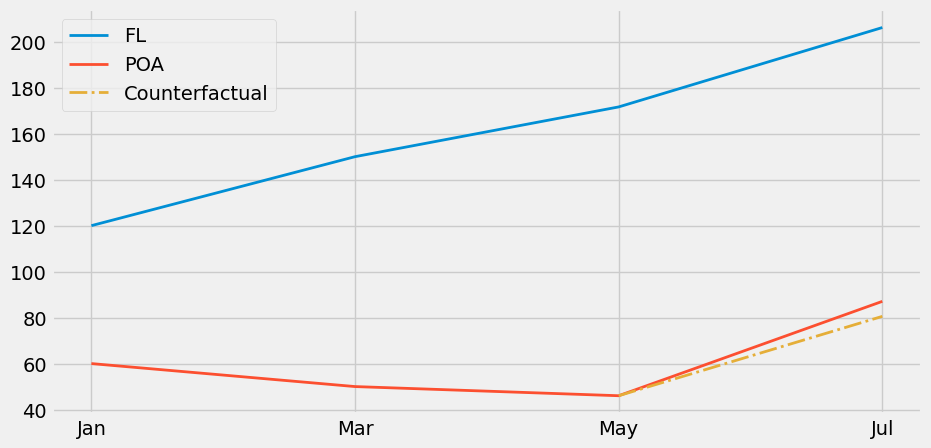

In [8]:
plt.figure(figsize=(10,5))
x = ["Jan", "Mar", "May", "Jul"]

plt.plot(x, [120, 150, fl_before,  fl_after], label="FL", lw=2)
plt.plot(x, [60, 50, poa_before, poa_after], label="POA", lw=2)

plt.plot(["May", "Jul"], [poa_before, poa_before+(fl_after-fl_before)], label="Counterfactual", lw=2, color="C2", ls="-.")

plt.legend();

앞으로 `synthetic control`(합성 대조군)으로 문제를 해결하는 방법을 배울 예정입니다. 합성 대조군은 여러 도시 데이터로 관심 도시의 추세를 밀접하게 따르는 합성 도시를 만드는 방법입니다. 아직은 `Diff-in-Diff`를 적용할 때 항상 평행 추세가 있는지 확인해야 합니다.

![img](./data/img/diff-in-diff/non-parallel.png)

마지막으로 주의해야 할 점으로 집계 데이터만 있다면 `Diff-in-Diff`에서 신뢰 구간을 얻을 수 없습니다. 포르투알레그리나 플로리아노폴리스의 개별 고객 데이터가 없다고 생각해봅시다. 대신 개입 전후로 두 도시의 평균 예금만 가지고 있습니다. 이 경우 `Diff-in-Diff`로 인과효과는 추정할 수 있지만, 분산은 알 수 없습니다. 데이터의 분산은 평균값을 취하면서 사라지기 때문입니다.

## Key Ideas

13장에서는 거시적인(학교, 도시, 주, 국가 등) 변화의 인과효과를 추정할 때 널리 사용하는 기술을 배웠습니다. `Diff-in-Diff`은 개입 전후 실험군과 대조군을 비교합니다. `Diff-in-Diff`로 어떻게 도시별 광고 효과를 구하는지 살펴보았습니다.

또한, 실험군과 대조군의 추세가 다를 때 `Diff-in-Diff`에 편향이 생기는 문제와 집계된 데이터만 있을 때 분산을 구할 수 없는 문제를 확인했습니다.

## References

I like to think of this entire book as a tribute to Joshua Angrist, Alberto Abadie and Christopher Walters for their amazing Econometrics class. Most of the ideas here are taken from their classes at the American Economic Association. Watching them is what is keeping me sane during this tough year of 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

I'll also like to reference the amazing books from Angrist. They have shown me that Econometrics, or 'Metrics as they call it, is not only extremely useful but also profoundly fun.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

Other important reference is Miguel Hernan and Jamie Robins' book. It has been my trustworthy companion in the most thorny causal questions I had to answer.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

Finally, I'd also like to compliment Scott Cunningham and his brilliant work mingling Causal Inference and Rap quotes:

* [Causal Inference: The Mixtape](https://www.scunning.com/mixtape.html)

![img](./data/img/poetry.png)

## Contribute

Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).